# Sentiment Analysis of the 2016 Presidential Election using Twitter

## Introduction

The results of the recent presidential election have been polemic and controversial in the U.S and around the world. People are very touched and use social media to express their feelings. What shocks people the most is how inaccurate the polls are as many of them forecasted an easy win for Democratic nominee Hillary Clinton. While data scientists are scrambling to figure out why their prediction models were flawed, a number of social media analytics firms have started to present their own models with data from major social media channels and shown relatively accurate prediction [1].

SimplyMeasured saw that social media sentiment towards Donald Trump trended more positively than sentiment towards Hillary Clinton on Election Day [2]. A similar trend was spotted by the analytics firm 4C insights, which found that Trump had more support on Facebook and Twitter from the beginning of October through November 7th [3]. "Positive sentiment for Trump was 58% to Clinton's 48%", the firm said [4]. And Brandwatch's analysis also found that Trump had more Twitter mentions [5].

To the best of our knowledge, most of the social media analysis models are built upon a time series of data. They are designed to show the trend of positive sentiment for each candidate. None has carried out a geographical analysis yet. In this work, we performed sentiment analysis on tweets from different states of US using the Twitter API and compared our results with the election results of each state. We specifically tried to answer the following questions:

* Can we use Twitter data to build a classifier for the 2016 US presidential election?

* Are the sentiment analysis results of tweets comparable with true election results?


## Libraries

For this project, you will use the libraries listed below:


In [7]:
import tweepy
import nltk
import itertools
from collections import Counter
import numpy as np
import sys
import pandas as pd
import re
import string
from string import digits
from nltk.corpus import stopwords
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Data Collection

For this project, we will be extracting data from Twitter using the Python library tweepy. Tweepy offers a variety of wrappers around the Twitter API, making it easier for the user to obtain data. However, the Twitter API has some limitations regarding historical data as it can only extract data from within the past week when searching for hashtags and/or location. But we found out that if you search using each specific user's id, you would be able to obtain his/her historical tweets.

So our final approach is to find users for each state that are currently tweeting about the election, whom we assume to be more likely to tweet at that time as well, and then query for their tweets during the election time frame.

### 1. Authentication

First, we need to authenticate our account.

In [11]:
import json

with open('config.json') as data_file:    
    data = json.load(data_file)

In [12]:
consumer_key = data["consumer_key"]
consumer_secret = data["consumer_secret"]
access_token = data["access_token"]
access_token_secret = data["access_token_secret"]

In [15]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

After our account is authenticated, we can initiate our data collection.

### 2. Collecting Users By State

Let us now collect users that recently tweeted about the election by their states.

For each state, we specify a geographical area with the longitude, latitude and radius within which we are going to select users. We experimented with the location parameters to find the optimum radius for each area. We decided to focus on big cities, and to not skew the data too much towards Clinton, we tried to select smaller cities in each state as well. Nonetheless, we expect the data to be skewed towards Clinton.

Due to limited amount of time, we are only going to perform the analysis among 24 of all 52 states, including the most critical ones, like Pennsylvania, Florida, Iowa, etc.


In [16]:
geocodes = {
    'CA': ["36.7783,-119.4179,40mi", "38.167014,-121.723139,30mi", '35.404784,-118.888667,80mi'],
    'TX': ["32.769732,-96.901585,25mi", '31.909753,-102.197028,35mi', '33.564888,-101.764114,25mi', '35.210314,-101.725662,25mi', '29.740337,-95.550393,35mi'],
    'PA': ['40.467857,-79.914755,35mi', '40.536721,-76.221279,40mi', '41.323314,-75.796996,10mi'],
    'AL': ['33.544256,-86.812935,35mi', '30.705623,-88.149418,10mi'],
    'MI': ['42.926319,-85.641269,40mi', '42.734965,-84.506931,40mi', '42.306825,-83.628840,35mi'],
    'CO': ['38.574031,-104.677154,35mi', '39.714674,-104.917480,30mi'],
    'IA': ['42.130077,-93.615018,100mi', '41.914816,-91.417752,25mi'],
    'AZ': ['33.100690,-111.938283,80mi'],
    'CT': ['41.676914,-72.699829,25mi'],
    'DC': ['38.892852,-76.990545,15mi'],
    'MO': ['38.747478,-92.286080,40mi', '37.214840,-93.428658,40mi', '39.087678,-94.505237,15mi'],
    'NV': ['36.165426,-115.268451,10mi', '39.167750,-119.695674,20mi', '39.584059,-119.742395,15mi'],
    'FL': ['25.730290,-80.255068,35mi','28.478014,-81.463564,35mi', '27.964959,-82.309511,20mi'],
    'NM': ['35.040469,-106.563015,35mi', '32.310137,-106.869259,20mi'],
    'VA': ['37.525185,-77.463871,60mi', '36.851270,-76.167484,75mi'],
    'IL': ['41.8781,-87.6298,30mi', '39.7817,-89.6501,20mi'],
    'MN': ['44.9778,-93.2650,20mi', '46.7867,-92.1005,10mi'],
    'WI': ['43.0731,-89.4012,20mi', '43.0389,-87.9065,20mi', '44.8113,-91.4985,20mi'],
    'WA': ['47.6062,-122.3321,50mi','47.6588,-117.4260,50mi', '46.2112,-119.1372,50mi'],
    'OR': ['45.5231,-122.6765,80mi','45.5229,-122.9898,80mi'],
    'VA': ['37.5407,-77.4360,80mi', '36.4029,-76.5550,60mi'],
    'NY': ['43.0481,-76.1474,30mi', '42.8864,-78.8784,20mi', '43.1610,-77.6109,10mi'],
    'NJ': ['40.2171,-74.7429,20mi', '40.5549,-74.4643,20mi', '40.816906,-74.210073,20mi'],
    'MD': ['39.2904,-76.6122,20mi', '39.4143,-77.4105,20mi'],
    'NC': ['35.7796,-78.6382,35mi', '36.0726,-79.7920,30mi'],
}

Also, probably due to some error in the twitter API, we found out that Tweepy sometimes returns users that are not really located in the state we are asking for. Therefore, we will use the following keywords to filter our results and ensure that locations are within the state we are requesting.


In [17]:
keywords = {'CA' : ['ca', 'los', 'la', 'san', 'bay', 'bev', 'hill', 'wood', 'jos', 'jose', 'dieg'],
            'TX' : ['tx', 'tex', 'dall', 'fort', 'worth', 'dallas', 'hous'],
            'PA' : ['pitt', 'pa', 'penn', 'scran', 'allen'],
            'AL' : ['al', 'birm', 'mobile'],
            'MI' : ['mi', 'grand'],
            'CO' : ['co', 'spring', 'denver'],
            'AZ' : ['az'],
            'CT' : ['ct', 'conn'],
            'MO' : ['mo', 'miss'],
            'NV' : ['nv', 'nev'],
            'DC' : ['wash', 'dc'],
            'IA' : ['ia', 'io', 'moi',],
            'FL' : ['fl', 'mia','orl'],
            'NM' : ['nm', "new", "mex", "albu", "sant", 'las'],
            'VA' : ['va', 'virgi', 'rich', 'norf', 'beach'],
            'IL' : ['il', 'chic', 'evan', 'spring'],
            'MN' : ['mn', 'st', 'paul', 'minn'],
            'WI' : ['wi', 'eau', 'milw', 'madi'],
            'WA' : ['seat', 'wa'],
            'OR' : ['port', 'or'],
            "NY" : ['ny', "new", "york"],
            'NJ' : ['nj', 'pater', 'jers', "newa"],
            'MD' : ['md', "mary"],
            'NC' : ['nc', 'north', 'caro'],
           }

Then for each state, we collect users that recently tweeted about the election this week. And we assume that they also tweeted during the election week.

Here is an example of how we did it for Texas. We already collected the users from all states and placed them in a csv file.

In [20]:
import time

# TWEETS FROM TEXAS
state = 'TX'
qs = ['trump'] # '#election2016', '#hillary', '#electionnight', '#electionday']
users = set()
for q in qs:
    for i in range(len(geocodes[state])):
#         time.sleep(0.1)
        places = tweepy.Cursor(api.search, q=q, geocode=geocodes[state][i])
        for page in places.pages(20):
            for tweet in page:
                loc, name = tweet.user.location.lower(), tweet.user.screen_name
                for kw in keywords[state]:
                    if kw in loc:
                        users.add((tweet.user.screen_name, tweet.user.location))

TweepError: Twitter error response: status code = 429

In [21]:
print len(users)
for u, loc in list(users)[:5]:
    print u, loc

0


In [22]:
df_dict = {
    'screen_name' : map(lambda x: x[0], users),
    'location'    : state
}

In [23]:
user_df = pd.DataFrame.from_dict(df_dict)
user_df.to_csv("tx_users.csv", header=False, mode='a')

### 3. Collecting Training Data

Tweepy has some limitations. One of them is that it doesn't allow to extract tweets in a specific time range. However, we have found some code in Github that allows to specify a time frame to extract tweets. The code can be found here.
The code below is to extract 1500 tweets from the night of the election by searching Trump or Clinton in the tweets using the library of the link above. But the data extracted was skewed towards Clinton which led to low prediction accuracy. Therefore, we searched for 500 tweets for each of the following hashtags: #MakeAmericaGreat, #IamWithHer and #electionNight. By using this approach, the data is more balanced between the two candidates.


In [24]:
import TweetCriteria as tc
import TweetManager as tm

ImportError: No module named TweetCriteria

In [ ]:
import csv
writefile = open("training.csv", "wb")
outputfile = csv.writer(writefile)

In [ ]:
tweetCriteria = tc.TweetCriteria().setQuerySearch('#MakeAmericaGreat').setSince('2016-11-09').setUntil('2016-11-10').setMaxTweets(500)
tweet = tm.TweetManager().getTweets(tweetCriteria)
for tw in tweet:
    # Encoding is required since the tw.text is a unicode string
    outputfile.writerow([tw.text.encode('ascii','ignore'), tw.date])

In order to ensure that the code implemented above is reliable, we have validated these tweets with the tweets obtained using Tweepy.

After that, the tweets are manually labeled as 0, 1, 2 for neutral, Trump and Clinton, respectively. These tweets are then saved in a csv file called "trainingfinal.csv".

Now let's do some pre-processing.

## Data Pre-processing

First, we load the data.

In [ ]:
data = pd.read_csv('trainingfinal.csv', header=None)
train = np.array([str(tweet) for tweet in data[1]])
label = data[0]

We would like to parse each tweet into separate words and tokenize them. We used the nltk package to tokenize and we removed all the noises. This includes removing "@somebody", URLs, numbers, stopwords, punctuations and capitalization in each tweet.


In [25]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    '''
        input:
            text: a string corresponding to one tweet
            lemmatizer: default is nltk.stem.wordnet.WordNetLemmatizer()
        output:
            result: a list of tokenized words
    '''
#     Remove numbers
    text = text.translate(None, digits)
    # Normalizes case
    text = text.lower()
    # remove apostrophes, delete 's
    text = text.replace("'s", '')
    text = text.replace("'", '')
    # Remove @ and URLs
    text = re.sub('@\w+\s', '', text)
    text = re.sub('(http|http).*$', '', text)
    # Remove punctuations
    for char in string.punctuation:
        text = text.replace(char, ' ')
    # Tokenize the tweet
    result = []
    for word in nltk.tokenize.word_tokenize(text):
        # Remove stopwords
        if word not in stopwords.words('english'):
            try:
                result.append(lemmatizer.lemmatize(word))
            except Exception:
                pass
    return result

After pre-processing the words from each tweet are joined back together as one string.


In [ ]:
processed_tweets = map(lambda tw: ' '.join(process(tw)), train)

In [ ]:
print "Example sentence after tokenizing: "
for i in range(5, 10):
    print processed_tweets[i]

In [ ]:
print len(processed_tweets)
print "Trump Supporter", len(label[label == 1])
print "Clinton Supporter", len(label[label == 2])
print "Neutral", len(label[label == 0])

## Modeling

### 1. First divide the training data into training and development set

Because the tweets are totally random, we simply split them and used the first 70% as the training set and the last 30% as the development set.


In [ ]:
n = int(.7 * len(processed_tweets))
train_tweet = processed_tweets[:n]
dev_tweet = processed_tweets[n: ]
train_label = label[:n]
dev_label = label[n:]

### 2. SVM Classifier

On the following code, we estimated the best parameters for the SVM classifier by experimenting with different kernel types and regularization term.


In [ ]:
from sklearn import svm
# Remove the stopwords and create the features
stopwords = nltk.corpus.stopwords.words('english') 
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(train_tweet)
X_dev = vectorizer.transform(dev_tweet)


In [ ]:
for kernel in ['rbf', 'linear', 'sigmoid', 'poly']:
    for C in [1e2, 1e3, 1e4, 1e5]:
        clf_svm = svm.SVC(kernel=kernel, C=C)
        clf_svm.fit(X, train_label)
        print kernel, C, clf_svm.score(X_dev, list(dev_label))

Based on the above results, the best kernel type is rbf and the best C is 1e3.
Let's train the classifier with these optimum parameters.

In [ ]:
X = vectorizer.fit_transform(processed_tweets)
clf_svm = svm.SVC(kernel = 'rbf', C = 1e3)
clf_svm.fit(X, label)

### 3. Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
X = vectorizer.transform(train_tweet)
X_dev = vectorizer.transform(dev_tweet)
clf_nb = MultinomialNB()
clf_nb.fit(X, train_label)
clf_nb.score(X_dev, list(dev_label))

## 4. Word2Vec


In [34]:
from gensim.models import word2vec

In [35]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [36]:
# Prepare the tokenized sentences
processed_tweets = map(lambda tw: process(tw), train)

NameError: name 'train' is not defined

In [37]:
model = word2vec.Word2Vec(processed_tweets, workers=num_workers, \
                          size=num_features, min_count = min_word_count, \
                          window = context, sample = downsampling)
model.init_sims(replace=True)
model_name = "SA"
model.save(model_name)

NameError: name 'processed_tweets' is not defined

In [ ]:
model.doesnt_match("man woman child kitchen".split())

In [ ]:
model.most_similar("queen")


Since the Naive Bayes classifier had a lower accuracy, we decided to use the SVM classifier with its optimum parameters to make predictions

## Predicting Supporters in Each State

We now have all the tools required to find the affiliation of each user for each state.

First let's load users by state from the csv file we created and put them in a dictionary.

In [ ]:
users_df = pd.read_csv('clean_users.csv')
users_by_state = dict()
for state in keywords:
    users_by_state[state] = list(set(list(users_df['screen_name'][users_df['location'] == state])))
    
print users_df['location'].unique()
['CA' 'TX' 'PA' 'AL' 'MI' 'CO' 'AZ' 'CT' 'MO' 'NV' 'DC' 'IA' 'FL' 'NM' 'VA'
 'WA' 'OR' 'MN' 'IL' 'WI' 'NY' 'NJ' 'MD' 'NC']

Then we defined a find_affiliation function. Given all the tweets of a user, it returns Trump if there are more pro-trump tweets, Clinton if there are more pro-clinton tweets, Other if there are an equal number of them.


In [ ]:
def find_affiliation(clf, vectorizer, tweets):
    ret = clf.predict(vectorizer.transform(tweets))
    trump = sum(ret == 1)
    clinton = sum(ret == 2)
    if trump > clinton:
        return "Trump"
    elif clinton > trump:
        return "Clinton"
    else:
        return "Other"

Now that we have the find_affiliation function we can find the number of users that support each candidate.


In [26]:
# PREDICTIONS IN TEXAS
def predict_state(clf, vectorizer, users_by_state, affiliations, state="TX"):
    affiliations[state] = dict()
    affiliations[state]['Trump'] = 0
    affiliations[state]['Clinton'] = 0
    affiliations[state]['Other'] = 0
    for name in users_by_state[state]:
        tweetCriteria = tc.TweetCriteria().setUsername(name).setQuerySearch('election').setSince("2016-11-09").setUntil('2016-11-11').setMaxTweets(100)
        tweet = tm.TweetManager().getTweets(tweetCriteria)
        if tweet:
            aff = find_affiliation(clf, vectorizer,
                    map(lambda tw: tw.text, tweet))
            affiliations[state][aff] += 1
        else:
            affiliations[state]['Other'] += 1

Here is the code that performs the classification for each state. It takes a lot of time to run and therefore we stored the result in a dictionnary to avoid multiple runs.


In [ ]:
aff = dict()
for state in keywords:
    predict_state(clf_svm, vectorizer, users_by_state, aff, state)
    print state, aff[state]

In [27]:
results = {
    'VA': {'Other': 72, 'Clinton': 12, 'Trump': 22},
    'CO': {'Other': 82, 'Clinton': 15, 'Trump': 13},
    'NM': {'Other': 146, 'Clinton': 10, 'Trump': 25},
    'TX': {'Other': 344, 'Clinton': 45, 'Trump': 66},
    'CA': {'Other': 221, 'Clinton': 31, 'Trump': 42},
    'MN': {'Other': 128, 'Clinton': 20, 'Trump': 14},
    'MI': {'Other': 176, 'Clinton': 25, 'Trump': 41},
    'AL': {'Other': 106, 'Clinton': 15, 'Trump': 22},
    'WI': {'Other': 162, 'Clinton': 29, 'Trump': 27},
    'DC': {'Other': 21, 'Clinton': 8, 'Trump': 4},
    'PA': {'Other': 160, 'Clinton': 44, 'Trump': 49},
    'IL': {'Other': 121, 'Clinton': 20, 'Trump': 20},
    'OR': {'Other': 137, 'Clinton': 18, 'Trump': 12},
    'IA': {'Other': 146, 'Clinton': 17, 'Trump': 31},
    'WA': {'Other': 131, 'Clinton': 22, 'Trump': 22},
    'AZ': {'Other': 57, 'Clinton': 18, 'Trump': 24},
    'FL': {'Other': 150, 'Clinton': 33, 'Trump': 44},
    'MD': {'Other': 146, 'Clinton': 16, 'Trump': 34},
    'NJ': {'Other': 100, 'Clinton': 11, 'Trump': 21},
    'NC': {'Other': 223, 'Clinton': 25, 'Trump':27},
    'MO': {'Other': 148, 'Clinton': 25, 'Trump': 30},
    'NV': {'Other': 113, 'Clinton': 17, 'Trump': 40},
    'CT': {'Other': 83, 'Clinton': 11, 'Trump': 27},
    'NY': {'Other': 162, 'Clinton': 42, 'Trump': 42},
}

## Analysis of Results

Based on the above results, we can see that Trump was predicted as the winner for most of the states selected.

The first explanation we can give is the limitations on the tools we used. It was indeed hard to select users that tweeted during election time frame, so we had to make perhaps invalid assumptions and had to combine different APIs in order to collect users, the tweets of those users and the training data.

For some states like California and Washington, we believe that another reason is the fact that more people were tweeting about Trump's victory after the election night, which might have confused the classifier. Also, after the results were released, some of the Trump supporters were probably more open about their views than Clinton Supporters.

Another explanation for our results to be biased towards Trump can be the sample population obtained to test the classifier. Even though we extracted about 200 users per state, most of them did not tweet during the election which reduced the sample size.

Here is the map of our prediction.


Here is the map of real election results of the corresponding states


Now let's go into more details into some of the state.

In [28]:
real_results = {'NY': [61.0, 39.0], "CO": [51.6, 48.4], "PA": [49.4, 50.6]}
predicted_results = {"NY": [50.0, 50.0], 'CO': [53.6, 46.4], 'PA': [47.3, 52.7]}
# Some of this code comes from: http://matplotlib.org/examples/api/barchart_demo.html
def plot_state(state):
    actual = real_results[state][0]
    actual1 = real_results[state][1]
    predicted = predicted_results[state][0]
    predicted1 = predicted_results[state][1]
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    ## the data
    N = 1

    ## necessary variables
    ind = np.arange(N)
    width = 0.35

    ## the bars
    rects1 = ax.bar(ind, actual, width, color='blue')
    rects2 = ax.bar(ind+width, predicted, width, color='lightsteelblue',hatch = '/')
    rects3 = ax.bar(ind+width*3, actual1, width, color='red')
    rects4 = ax.bar(ind+width*4, predicted1, width, color='lightcoral',hatch = '/')
    # axes and labels
    ax.set_xlim(-width,len(ind)+width*3)
    ax.set_ylim(0,80)
    ax.set_ylabel('Votes (%)')
    ax.set_title('New York Results')
    xTickMarks = ['Clinton', 'Trump']
    ax.set_xticks((ind+width, ind+width*4))
    xtickNames = ax.set_xticklabels(xTickMarks)
    plt.setp(xtickNames, fontsize=10)

    ## add a legend
    ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Actual', 'Predicted', 'Actual', 'Predicted') )
    plt.show()

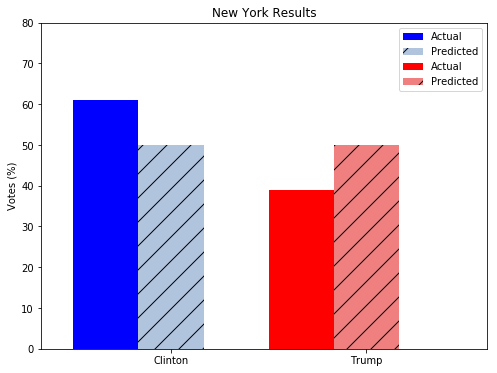

In [29]:
plot_state("NY")

We know that most Clinton supporters are in New York City, but the twitter API made it difficult to collect enough users due to the location and size of the state. We thus had to collect tweets from smaller cities such as Rochester and Buffalo that are generally more diverse. This is probably why we have a tie in New York. We had a similar issue in New Jersey. This also made it nearly impossible for us to collect enough tweets from the East Coast.

Nonetheless we can't really explain why the classifier fails in California. We did not encounter any problem collecting the data and yet we made incorrect predictions. Figuring this out would be interesting future work.

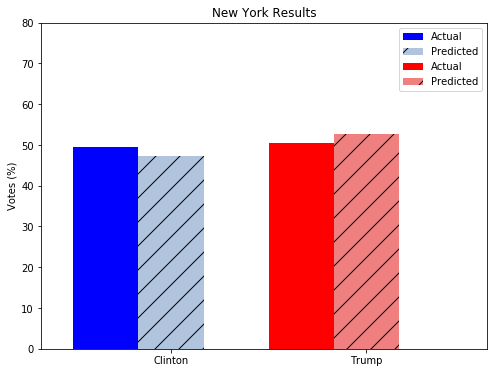

In [32]:
plot_state("PA")


As you can see, the results in Pennsylvania correspond almost perfectly to reality. This is due to the fact that we had no problem collecting a lot of tweets from a big city like Pittsburgh and from smaller cities such as Scranton and Allentown. This allows us to have a more representative sample.


Here again, the predictions were relatively correct. This can also be explained by the ease with which we collected tweets from both small and big cities and how representative our sample was.


# Conclusions

This project trained a SVM classifier for sentiment analysis on tweets extracted randomly using the Python library Tweepy. The purpose of training this classifier is to predict the presidential candidates Clinton and Trump for different states across the US. Tweepy has some limitations with regards to extracting old tweets for a specific location. In order to overcome this problem, another library named "GetOldTweets" was used. The results showed that the classifier predicted poorly on most of the states where Clinton won. We believed that this problem comes from the difficulties to collect data from big cities, which forced us to search into smaller cities. In addition, since the training set and test sets come from different sources, this probably increased the noise in our data.

Our overall results are loosely related to the actual results, but they show that Twitter contains enough data to build socio-political models. It would be interesting to know what kind of results better tools could have produced.



# References

techcrunch: Analysis of social media did a better job at predicting Trump's win than the polls

simplymeasured.com: Trump vs Clinton the mood on social before the final debate

4cinsights: Election night 2016 impact report